In [13]:
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# loading data

In [206]:
data1 = pd.read_csv('Playstore_final.csv', encoding='utf-8')
data2 = pd.read_csv('GooglePlay.csv')

/var/folders/11/84r3xqcs2r11xfd_p2ck35p80000gn/T/ipykernel_9973/3159704935.py:1: DtypeWarning: Columns (7,12,29,30,33,35,37,38,40,42,43,44,46,47,48,49,50,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('Playstore_final.csv', encoding='utf-8')


# Handling missing values

# Cleaning data

In [207]:
def remove_character(data, replacements):
    for column, characters in replacements:
        data[column] = data[column].str.replace(characters, '')
    return data
    
def change_data_type(data,colmns_type):
    for col , data_type in colmns_type:
        if data[col].dtype == 'object':
            data[col] = pd.to_numeric(data[col], errors='coerce')
            data[col] = data[col].astype(data_type)
    return data
    
data1 = remove_character(data1, [('Size','M'),('Installs','+'),('Installs' , ',')])
data1 = change_data_type(data1, [('Size','Float64'),('Installs','Float64'),('Installs' , 'Float64')])

data2 = remove_character(data2 , [('Size','M'), ('Installs','+'),('Installs' , ',')])
data2 = change_data_type (data2 , [('Size','Float64'),('Reviews','Float64'),('Installs' , 'Float64') , ('Price' ,'Float64' )] ) 

In [208]:
from datetime import datetime, timedelta

def parse_date(date):
    try:
        return pd.to_datetime(date, format='%d-%b-%y')
    except ValueError:
        return np.nan
        
data1['Released'] = data1['Released'].apply(parse_date)
data1['Last update'] = data1['Last update'].apply(parse_date)
data2['Last Updated'] = data2['Last Updated'].apply(parse_date)



### removing records with more than X null values

In [209]:
data2 = data2[data2.isnull().sum(axis=1) <= 2]
data2.isna().sum()

Unnamed: 0           0
App                  0
Category             0
Rating            1444
Reviews              0
Size              1981
Installs             0
Type                 0
Price              773
Content Rating       0
Genres               0
Last Updated         0
Current Ver          5
Android Ver          2
dtype: int64

### Filling NuLL Value with the mean of a column

In [210]:
def fill_nulls (data , collumns , fillig_type):
    X = data[collumns].mean()

    if fillig_type == 'mean':
        X = data[collumns].mean()
    elif fillig_type == 'max':
        X = data[collumns].max()
    elif fillig_type == 'mode':
        X = data[collumns].mode()
    data[collumns] = data[collumns].fillna(X)
    return data

data1 = fill_nulls(data1 , ['Price', 'Rating Count', 'Size','Installs'] ,  'mean')
data2 = fill_nulls(data2 , ['Size' ,'Price'] , 'mean')

### using regression to fill null values

In [211]:

def fill_with_regression(orig_data ,column_to_fill , other_numeric_columns ):
    data = orig_data[other_numeric_columns]
    X = data.dropna(subset=[column_to_fill])  
    X = X.drop(columns=[column_to_fill])  
    y = data.dropna(subset=[column_to_fill])[column_to_fill]
    
    regressor = LinearRegression()
    regressor.fit(X, y)
    
    X_missing = data[data[column_to_fill].isnull()].drop(columns=[column_to_fill])
    predicted_values = regressor.predict(X_missing)
    
    data.loc[data[column_to_fill].isnull(), column_to_fill] = predicted_values
    orig_data[column_to_fill] = data[column_to_fill]
    return orig_data

data1 = fill_with_regression(data1 , 'Rating' ,  ['Rating', 'Price','Rating Count', 'Size','Installs'] )
data2 = fill_with_regression(data2 , 'Rating' , ['Rating', 'Price','Reviews', 'Size','Installs'] )

## data conversion

### normalizing the data

In [24]:
def data_normalizer(data , columns_to_normalize ): 
    scaler = MinMaxScaler()
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
    return data
    
data1 = data_normalizer(data1 , ['Rating', 'Minimum Installs', 'Price','Minimum Installs','Reviews','Installs','Rating Count'])
data2 = data_normalizer(data2 , ['Rating', 'Price','Reviews', 'Size','Installs'])

In [25]:
data1.head(10)

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Logistics Management,com.eniseistudio.logistics_management,Education,0.818182,4.544767e-07,1.000000e-06,1.000000e-06,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Estados Unidos Noticias,com.eniseistudio.news.estados_unidos,News & Magazines,0.800000,3.606958e-08,1.000000e-07,1.000000e-07,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dental Assistant,com.eniseistudio.dental_assistant,Education,0.773333,8.656700e-08,1.000000e-06,1.000000e-06,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Medical Assistant,com.eniseistudio.course.medical_assistant,Education,0.800000,1.082087e-07,5.000000e-07,5.000000e-07,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Business Administration,com.eniseistudio.majors.course.business_admini...,Education,0.804651,5.987551e-07,5.000000e-06,5.000000e-06,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Economics,com.eniseistudio.economics,Education,0.827723,1.587062e-06,1.000000e-05,1.000000e-05,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Cosmetology,com.eniseistudio.course.cosmetology,Education,0.484211,1.154227e-07,5.000000e-07,5.000000e-07,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Learn Python,com.jquiz.python,Education,0.000000,1.401393e-04,1.000000e-09,1.000000e-09,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Quality Management,com.eniseistudio.quality_management,Education,0.866667,2.164175e-08,5.000000e-07,5.000000e-07,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tourism Management,com.eniseistudio.tourism_management,Education,0.946154,1.659201e-07,1.000000e-06,1.000000e-06,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# making new features

In [34]:
import pandas as pd
import numpy as np
# new feature from Installs and Rating Count
data1['Engagement_Score'] = np.log(data1['Installs']) * np.log(data1['Rating Count'])

data1[['Installs', 'Rating Count', 'Engagement_Score']].head(10)


   Installs  Rating Count  Engagement_Score
0   10000.0  5.737188e-07       -132.362966
1    1000.0  3.701412e-08       -118.205276
2   10000.0  1.017888e-07       -148.289846
3    5000.0  1.295494e-07         -135.0759
4   50000.0  7.587894e-07       -152.467355
5  100000.0  2.026523e-06       -150.925116
6    5000.0  1.388029e-07       -134.488274
7      10.0  2.050765e-04        -19.553846
8    5000.0  1.850706e-08       -151.649592
9   10000.0  2.035777e-07       -141.905725


/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/masked.py:582: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# removing outlier records

In [212]:
def remove_outliers(data, columns, threshold=1.5):

    cleaned_data = data.copy()
    for column in columns:
        Q1 = cleaned_data[column].quantile(0.25)
        Q3 = cleaned_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        cleaned_data = cleaned_data[(cleaned_data[column] >= lower_bound) & (cleaned_data[column] <= upper_bound)]
    return cleaned_data
    
data1 = remove_outliers(data1 , ['Rating','Size' ,'Installs' ] , threshold=3)
data2 = remove_outliers(data2 , ['Rating', 'Price','Reviews', 'Size','Installs'] , threshold = 3)

In [37]:
#old approach to removing outliers
# import pandas as pd
# import numpy as np
# from scipy import stats

# threshold = 3

# z_scores_rating = np.abs((data1['Rating'] - data1['Rating'].mean()) / data1['Rating'].std())
# z_scores_size = np.abs((data1['Size'] - data1['Size'].mean()) / data1['Size'].std())
# z_scores_installs = np.abs((data1['Installs'] - data1['Installs'].mean()) / data1['Installs'].std())

# combined_mask = (z_scores_rating < threshold) | (z_scores_size < threshold) | (z_scores_installs < threshold)
# data1 = data1[combined_mask]


# convert numerical data to categorical

In [29]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# selected_columns = ['Rating', 'Rating Count', 'Installs', 'Price','Content Rating']
# X = data1[selected_columns]

# label_encoder = LabelEncoder()

# for col in X.columns:
#     X[col] = label_encoder.fit_transform(X[col])

# X.head(10)


# Comparison between Sport Apps Rating with oveerall rating



In [58]:
import pandas as pd
from scipy.stats import ttest_ind


sports_ratings = data1[data1['Category'] == 'Sports']['Rating']

overall_avg_rating = data1['Rating'].mean()

t_statistic, p_value = ttest_ind(sports_ratings, data1['Rating'])

if p_value < 0.05:
    print("There is a significant difference between sports app ratings and overall average rating.")
else:
    print("No significant difference found.")

print(f"Sports Apps Average Rating: {sports_ratings.mean()}")
print(f"Overall Average Rating: {overall_avg_rating:.2f}")


There is a significant difference between sports app ratings and overall average rating.
Sports Apps Average Rating: 0.6395217033089713
Overall Average Rating: 0.63


# data reduction 


### Dimensionality Reduction

In [213]:
data1 = data1[['App Name', 'App Id', 'Category', 'Rating', 'Rating Count', 'Installs',
       'Minimum Installs', 'Free', 'Price', 'Currency', 'Size',
       'Minimum Android', 'Developer Id', 'Released', 'Last update', 'Content Rating', 'Reviews']]
data2 = data2[[ 'App', 'Category', 'Rating', 'Reviews', 'Size',
       'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated',
       'Current Ver', 'Android Ver']]

In [131]:
pca = PCA(n_components=2)

selected_columns = ['Rating', 'Rating Count', 'Installs','Price']
X = data1[selected_columns]

principal_components = pca.fit_transform(X)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# data visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392151 entries, 0 to 392150
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PC1     392151 non-null  float64
 1   PC2     392151 non-null  float64
dtypes: float64(2)
memory usage: 6.0 MB


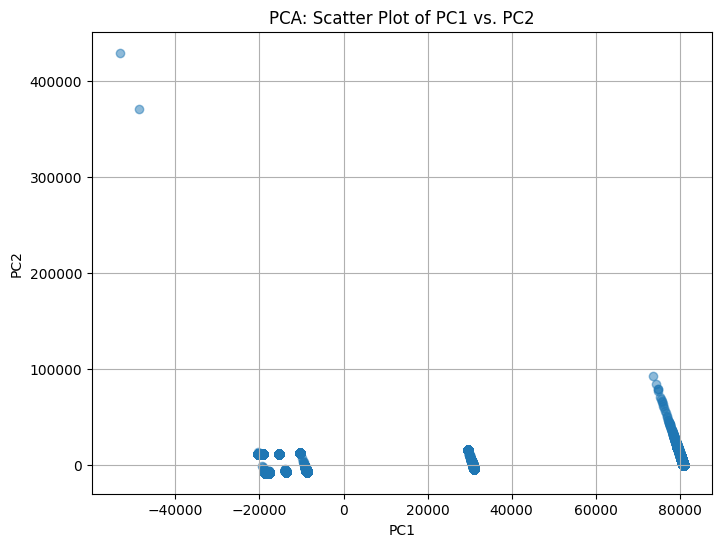

In [130]:

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Scatter Plot of PC1 vs. PC2')
plt.grid(True)
plt.show()

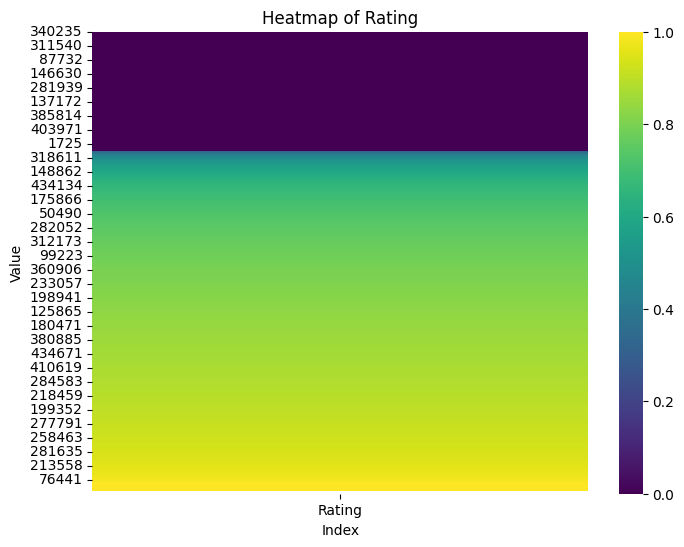

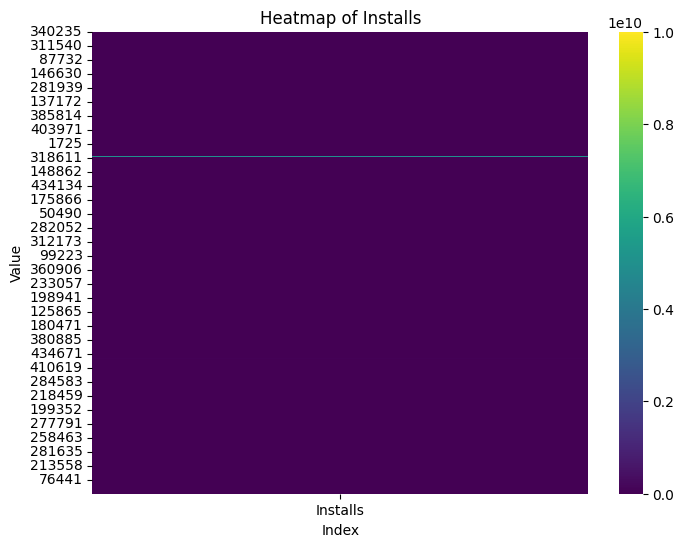

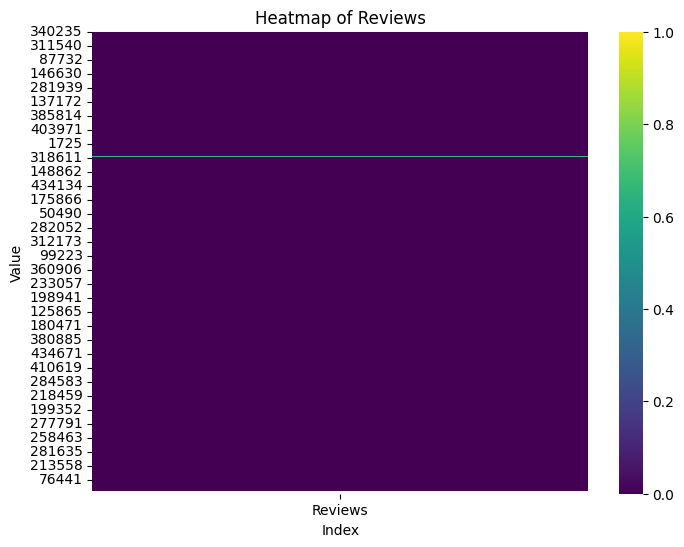

In [108]:
import matplotlib.pyplot as plt

columns = ['Rating', 'Installs','Reviews']
sort_by='Rating'
sorted_data = data1.sort_values(by=sort_by , ascending=True)

for col in columns:
    plt.figure(figsize=(8, 6))
    sns.heatmap(sorted_data[[col]], cmap='viridis', annot=False)
    plt.title(f'Heatmap of {col}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

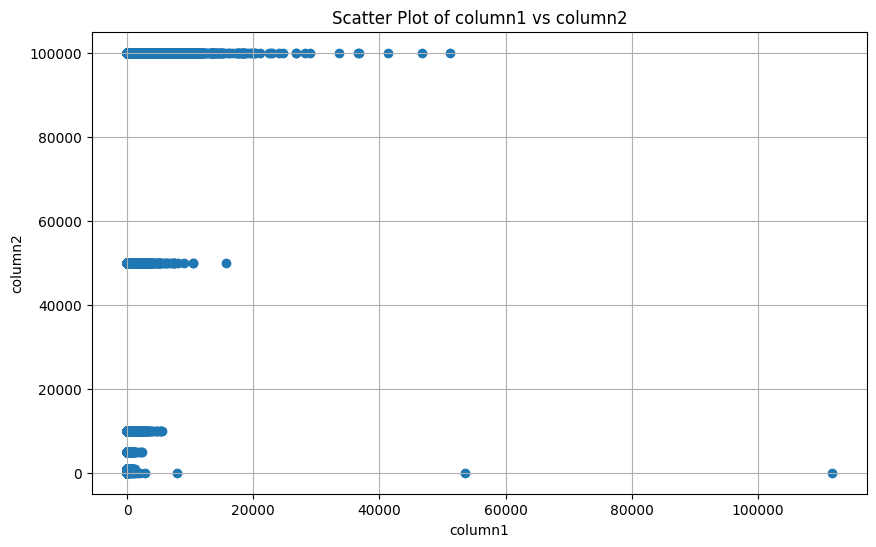

In [145]:
plt.figure(figsize=(10, 6))
plt.scatter(data1['Reviews'], data1['Installs'])
plt.title('Scatter Plot of column1 vs column2')
plt.xlabel('column1')
plt.ylabel('column2')
plt.grid(True)
plt.show()

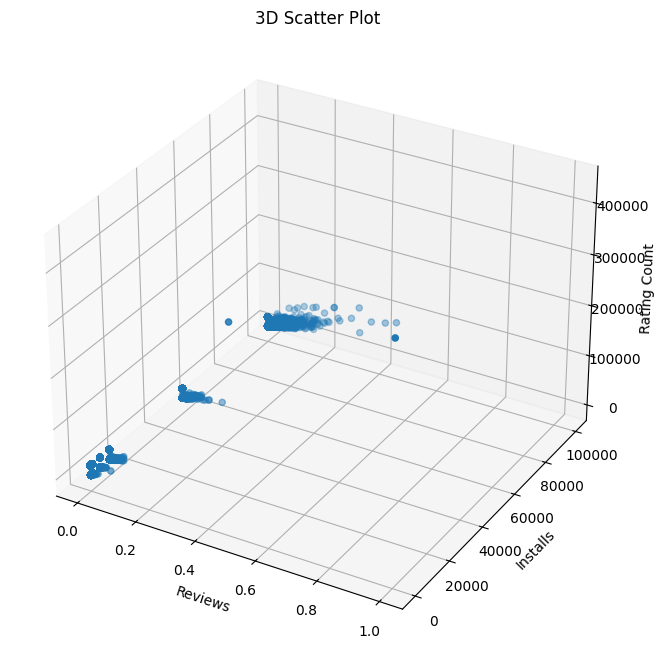

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Extract the three columns you want to visualize
x = data1['Reviews']
y = data1['Installs']
z = data1['Rating Count']

# Create a new figure and axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(x, y, z)

# Set labels and title
ax.set_xlabel('Reviews')
ax.set_ylabel('Installs')
ax.set_zlabel('Rating Count')
ax.set_title('3D Scatter Plot')

plt.show()


# data aggregation 

### assimilating related columns names

In [214]:
data2 = data2.rename(columns={'App': 'App Name'})
data2 = data2.rename(columns={'Type' :'Free'})
data1 = data1.rename(columns={'Last update' :'Last Updated'})
data1 = data1.rename(columns={'Category' :'Genres'})


### assimilating  related columns data type

In [269]:
data2['Free'] = data2['Free'].replace({'Pain': False, 'Free': True})

In [270]:
merged_df = pd.merge(data2, data1, on=['App Name','Genres'], how='left', suffixes=('_d2', '_d1'))


In [227]:
merged_df.head(10)

,App Name,Category,Rating_d2,Reviews_d2,Size_d2,Installs_d2,Free_d2,Price_d2,Content Rating_d2,Genres,...,Free_d1,Price_d1,Currency,Size_d1,Minimum Android,Developer Id,Released,Last Updated_d1,Content Rating_d1,Reviews_d1
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,True,0.0,Everyone,Art & Design;Pretend Play,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
2,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8,100000.0,True,0.0,Everyone,Art & Design;Creativity,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
3,Paper flowers instructions,ART_AND_DESIGN,4.4,167.0,5.6,50000.0,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
4,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178.0,19.0,50000.0,True,0.0,Everyone,Art & Design,...,True,0.0,USD,19.0,4.0.3,Anzu+Dev,2018-04-26,2018-04-26,Everyone,448.0
5,Infinite Painter,ART_AND_DESIGN,4.1,36815.0,29.0,1000000.0,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
6,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33.0,1000000.0,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
7,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121.0,3.1,10000.0,True,0.0,Everyone,Art & Design;Creativity,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
8,Text on Photo - Fonteee,ART_AND_DESIGN,4.4,13880.0,28.0,1000000.0,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
9,Name Art Photo Editor - Focus n Filters,ART_AND_DESIGN,4.4,8788.0,12.0,1000000.0,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN


In [271]:
def merge_column(data ,columns):
    for column in columns:
        # if two column ore equal or _d1 is null
        data[column] = data.apply(lambda row: row[column+'_d2'] if (not pd.notna(row[column+'_d1']) ) or
                                            row[column+'_d2'] == row[column+'_d1'] else np.nan, axis=1)
        # if both column are not null but both hase different values
        # we chose date from newest dataset 
        data[column] = data.apply(lambda row: row[column+'_d1'] if row['Last Updated_d1'] >=
                                            row['Last Updated_d2'] else row[column], axis=1)
        data.pop(column + '_d1')
        data.pop(column + '_d2')

    return data
merged_df = merge_column(merged_df , ['Size','Price' , 'Rating' , 'Reviews' , 'Installs','Free'])


In [272]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   App Name           7861 non-null   object        
 1   Category           7861 non-null   object        
 2   Content Rating_d2  7861 non-null   object        
 3   Genres             7861 non-null   object        
 4   Last Updated_d2    7861 non-null   datetime64[ns]
 5   Current Ver        7856 non-null   object        
 6   Android Ver        7859 non-null   object        
 7   App Id             1268 non-null   object        
 8   Rating Count       1268 non-null   float64       
 9   Minimum Installs   1268 non-null   float64       
 10  Currency           1268 non-null   object        
 11  Minimum Android    1267 non-null   object        
 12  Developer Id       1268 non-null   object        
 13  Released           1208 non-null   datetime64[ns]
 14  Last Upd

In [274]:
merged_df.head(30)

,App Name,Category,Content Rating_d2,Genres,Last Updated_d2,Current Ver,Android Ver,App Id,Rating Count,Minimum Installs,...,Developer Id,Released,Last Updated_d1,Content Rating_d1,Size,Price,Rating,Reviews,Installs,Free
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,19.0,0.0,4.100000,159.0,10000.0,True
1,Coloring book moana,ART_AND_DESIGN,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,14.0,0.0,3.900000,967.0,500000.0,True
2,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,2.8,0.0,4.300000,967.0,100000.0,True
3,Paper flowers instructions,ART_AND_DESIGN,Everyone,Art & Design,2017-03-26,1,2.3 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,5.6,0.0,4.400000,167.0,50000.0,True
4,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,Everyone,Art & Design,2018-04-26,1.1,4.0.3 and up,com.devanzu.smokeeffectphotomaker.smokeeditor,1114.0,100000.0,...,Anzu+Dev,2018-04-26,2018-04-26,Everyone,19.0,0.0,3.063063,448.0,100000.0,True
5,Infinite Painter,ART_AND_DESIGN,Everyone,Art & Design,2018-06-14,6.1.61.1,4.2 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,29.0,0.0,4.100000,36815.0,1000000.0,True
6,Garden Coloring Book,ART_AND_DESIGN,Everyone,Art & Design,2017-09-20,2.9.2,3.0 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,33.0,0.0,4.400000,13791.0,1000000.0,True
7,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,Everyone,Art & Design;Creativity,2018-07-03,2.8,4.0.3 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,3.1,0.0,4.700000,121.0,10000.0,True
8,Text on Photo - Fonteee,ART_AND_DESIGN,Everyone,Art & Design,2017-10-27,1.0.4,4.1 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,28.0,0.0,4.400000,13880.0,1000000.0,True
9,Name Art Photo Editor - Focus n Filters,ART_AND_DESIGN,Everyone,Art & Design,2018-07-31,1.0.15,4.0 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,12.0,0.0,4.400000,8788.0,1000000.0,True
